In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from sympy import *
from sympy.abc import r
from scipy.constants import G,k,m_p,e 
from scipy.integrate import quad 
from astropy.constants import M_sun as M
from astropy.constants import c
from tqdm import tqdm
from astropy.cosmology import Planck18 as cosmo
from aquarel import load_theme
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
conv=3.0856776e19

T0=(14.3*1e3/k)*e
r_cool=110*conv
a_cool=0.38
Tmin=(5.7*1e3/k)*e
rt=2800*conv
a=-0.07
b=2.5
c=4.3

mags=np.array([T0,r_cool,a_cool,Tmin,rt,a,b,c])

lowers=np.array([(-4.2*1e3/k)*e,-70*conv,-0.28,(-3.1*1e3/k)*e,-1400*conv,-0.12,-1.4,-3.0])
uppers=np.array([(12.5*1e3/k)*e,60*conv,0.38,(3*1e3/k)*e,1500*conv,0.09,1.7,3.8])

dt=0.5*(np.abs(lowers)+uppers)

In [3]:
def create_T(r,params,give_log=False):
    '''
    Expression for log of temperature
    '''
    r=symbols('r')
    [T0,r_cool,a_cool,Tmin,rt,a,b,c]=params
    left_nr=(((r/r_cool)**a_cool)+Tmin/T0)
    left_dr=((r/r_cool)**a_cool)+1
    right_nr=(r/rt)**(-a)
    right_dr=(1+(r/rt)**b)**(c/b)
    T=T0*left_nr*right_nr/left_dr/right_dr
    
    if give_log==False:
        return T
    
    return log(T)

def difftemp(param):
    
    '''
    log Temperature differentiated by r
    '''
    
    r=symbols('r')
    return diff(create_T(r,param,give_log=True),r)

In [4]:
mu=0.6
coeff=-k/(G*m_p*mu)/M

n0=7.6e3
rc=210*conv
alpha=1.42
be=0.55
rs=519.4*conv
e=1.32
gam=3

mags2=[n0,rc,alpha,be,rs,e]
lowers=[(-3.0)*1e3,-81*conv,-0.49,-0.16,-186.4*conv,-0.89]
uppers=[5.9e3,119.8*conv,0.28,0.13,316.4*conv,0.75]

dp=0.5*(np.abs(lowers)+uppers)

In [5]:
def create_logp(params):
    
    '''
    Calculate log of density
    '''
    
    r=symbols('r')
    [n0,rc,alpha,be,rs,e]=params
    
    l_nr=(r/rc)**(-alpha)
    l_dr=(1+(r**2/rc**2))**(3*be-0.5*alpha)
    r_dr=(1+(r/rs)**gam)**(e/gam)
    logp=log(1.624*m_p*n0)+0.5*log(l_nr)-0.5*log(l_dr*r_dr)
    
    return logp

def diffdens(params):
    
    return diff(create_logp(params),r)

### Part-1

In [6]:
def calc_newt_mass(rad, params_temp, params_dens):
    
    '''
    Calculate Newtonian Mass in Solar Masses
    '''
    T=create_T(rad,params_temp,give_log=False).subs(r,rad)
    dT=difftemp(params_temp).subs(r,rad)
    dP=diffdens(params_dens).subs(r,rad) 
    return (coeff*rad*T*((rad*dT+rad*dP))).value

In [7]:
def calc_mond_mass(rad, params_temp, params_dens):
    '''
    Calculate Mond Mass in Solar Masses
    '''
    m_newt=calc_newt_mass(rad,params_temp, params_dens)
    a=G*m_newt*M.value/(rad*rad)
    a0=1.2*10**-10
    return m_newt/(1+(a0/a)**2)**0.5

In [8]:
def create_f(params_dens,r):
    '''
    Lambda function for differential baryonic mass
    '''
    [n0,rc,alpha,be,rs,e]=params_dens
    f = lambda r:4*np.pi*(r**2)*1.624*m_p*n0*(((r/rc)**(-alpha)/(1+(r**2/rc**2))**(3*be-0.5*alpha))*(1/(1+(r/rs)**gam))**(e/gam))**0.5
    return f

def create_fp(params_dens, r, param, magsd):
    
    [n0,rc,alpha,be,rs,e]=params_dens
    r=symbols('r')
    
    f = 4*np.pi*(r**2)*1.624*m_p*n0*(((r/rc)**(-alpha)/(1+(r**2/rc**2))**(3*be-0.5*alpha))*(1/(1+(r/rs)**gam))**(e/gam))**0.5
    derivative=diff(f,param).subs(dict(zip(params_dens,magsd)))
    
    lambdified_func = lambdify(r, derivative, 'numpy')
    
    return lambdified_func

In [9]:
def calc_mobs(params_dens,rad):
    '''
    Calculate Newtonian Mass in Solar Masses
    '''
    mgas=quad(create_f(params_dens,r),0,rad)
    mstar=4e12*M.value*((mgas[0])/(5.7e13*M.value))**0.6
    return (mgas[0]+mstar)/M.value

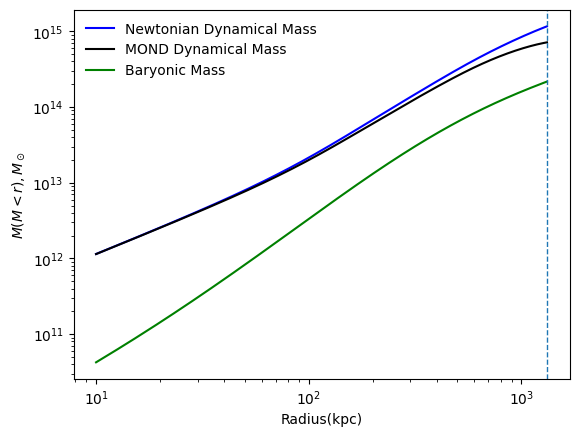

In [10]:
radius=np.linspace(10**1*conv,10**3.12*conv,1000)
params_temp=[T0,r_cool,a_cool,Tmin,rt,a,b,c]
params_dens=[n0,rc,alpha,be,rs,e]

newt_masses=np.array([calc_newt_mass(i,params_temp,params_dens) for i in radius])
mond_masses=np.array([calc_mond_mass(i,params_temp,params_dens) for i in radius])
obs_masses=np.array([calc_mobs(params_dens,i) for i in radius])

plt.xscale('log')
plt.yscale('log')

plt.plot(radius/conv,newt_masses,label='Newtonian Dynamical Mass',color='blue')
plt.plot(radius/conv,mond_masses,label='MOND Dynamical Mass',color='black')
plt.plot(radius/conv,obs_masses,label='Baryonic Mass',color='green')

plt.axvline(x=10**3.12,linestyle='--',linewidth=1)
plt.xlabel('Radius(kpc)')
plt.ylabel('$M(M<r) ,M_\odot$')
plt.legend(frameon=False)
plt.show()

In [11]:
def temp_errors(radius, t_errors, dens_params,temp_params,mags,magsd):
    
    '''
    Returns an array of summation of (dM_n/dphi)**2*sigma(phi)**2 across all phis(temp parameters) for all radii
    t_errors=Array of error magnitudes for temp parameters
    dens_params=Symbolic variables for density parameters
    temp_params=Symbolic variables for temperature parameters
    mags=Array of numerical values of temp parameters(eROSITA data fit)
    magsd=Array of numerical values of density parameters(eROSITA data fit)
    '''
    
    err_array=[]
    for rad in tqdm(radius):
        
        fin_res=0
        param_index=0
        
        T=create_T(r,temp_params)
        p=exp(create_logp(dens_params))
            
        x=diff(p,r)
        y=diff(T,r)

        for param in temp_params:
            
            u=diff(T,param)
            z=diff(y,param)

            
            res=coeff.value*r**2*(1/p*x*u+z)
            res=res**2*(t_errors[param_index])**2
            fin_res=fin_res+res
            param_index=param_index+1
            
        fin_res=fin_res.subs(dict(zip(dens_params,magsd))).subs(dict(zip(temp_params,mags))).subs({r:rad})
        err_array.append(fin_res)
        
    return err_array

In [12]:
def dens_errors(radius, dens_errors, dens_params,temp_params,mags,magsd):
    
    '''
    Returns an array of summation of (dM_n/dphi)**2*sigma(phi)**2 across all phis(density parameters) for all radii
    density_errors=Array of error magnitudes for density parameters
    dens_params=Symbolic variables for density parameters
    temp_params=Symbolic variables for temperature parameters
    mags=Array of numerical values of temp parameters(eROSITA data fit)
    magsd=Array of numerical values of density parameters(eROSITA data fit)
    '''
    err_array=[]
    
    for rad in tqdm(radius):
        
        fin_res=0
        param_index=0
        T=create_T(r,temp_params)
        p=exp(create_logp(dens_params))
        dp=diff(p,r)
        
        for param in dens_params:
            
            res=coeff.value*r**2*T*(-1/p/p*dp*diff(p,param)+1/p*diff(dp,param))
            res=res**2*(dens_errors[param_index])**2

            fin_res=fin_res+res
            param_index=param_index+1

        fin_res=fin_res.subs(dict(zip(dens_params,magsd))).subs(dict(zip(temp_params,mags))).subs({r:rad})
        err_array.append(fin_res)

    return err_array

In [13]:
#Symbols for temperature and density parameters

m,n,o,p,q,s,t,u=symbols('m n o p q s t u')
v,w,x,y,z,d=symbols('v w x y z d')

temp_params=[m,n,o,p,q,s,t,u]
dens_params=[v,w,x,y,z,d]

In [14]:
err1=np.array(temp_errors(radius,dt,dens_params,temp_params,mags,mags2))

100%|███████████████████████████████████████| 1000/1000 [06:11<00:00,  2.69it/s]


In [15]:
err2=np.array(dens_errors(radius,dp,dens_params,temp_params,mags,mags2))

100%|███████████████████████████████████████| 1000/1000 [05:24<00:00,  3.08it/s]


In [16]:
errors=(err1+err2)**0.5

In [17]:
def bary_errors(radius, dens_errors, dens_params, magsd):
    
    '''
    Calculate error in baryonic mass
    error in quad excluded
    '''
    justerrs=[[] for i in range(7)]
    res=[[] for i in range(7)]
    param_index=0
    
    r=symbols('r')    
    star_factor=4e12*(M.value)/(5.7e13*(M.value))**0.6
    expr2=create_f(params_dens,r)
        
    for param in tqdm(dens_params):

        expr=create_fp(dens_params,r,param,magsd)
        
        for rad in radius:
            
            mgas=quad(expr2,0,rad)[0]
            err=quad(expr,0,rad)[0]
            include_star=(1+star_factor*0.6*mgas**(-0.4))
            justerrs[param_index].append(err*include_star)
            err=(err*include_star)**2*dens_errors[param_index]**2
            res[param_index].append(err)

        
            if param_index==0:
                dif=star_factor*mgas**0.6*np.log(mgas/(5.7e13*M.value))
                f=dif**2*0.01
                res[6].append(f)
                justerrs[6].append(dif)
                
        param_index=param_index+1

    return res,justerrs

In [18]:
b_errors1,justerrs=bary_errors(radius, dp, dens_params, mags2)

100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.27it/s]


In [19]:
b_errors=np.array(b_errors1)
b_errors=((np.sum(b_errors,axis=0))**0.5)/M.value

In [20]:
cs_o_max=CubicSpline(radius,obs_masses+b_errors)
cs_o_min=CubicSpline(radius,obs_masses-b_errors)

cs_n_max=CubicSpline(radius,newt_masses+errors)
cs_n_min=CubicSpline(radius,newt_masses-errors)

a0=1.2e-10
term=((a0*radius**2)/G/newt_masses)**2
term=(1+term)**0.5
const=1/term*(2-(1/term/term))
m_errors=const*errors

cs_m_max=CubicSpline(radius,mond_masses+m_errors)
cs_m_min=CubicSpline(radius,mond_masses-m_errors)

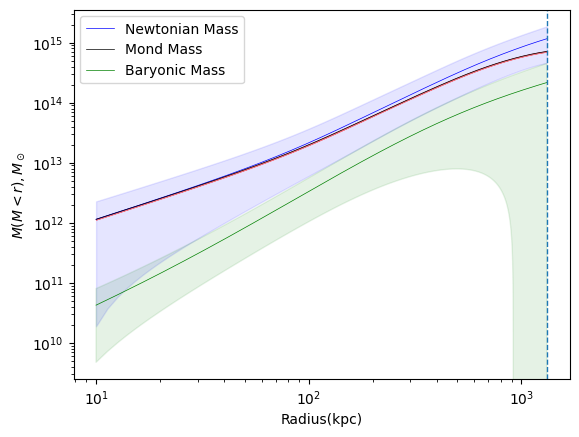

In [21]:
plt.xscale('log')
plt.yscale('log')

plt.plot(radius/conv,newt_masses,label='Newtonian Mass',color='blue',linewidth=0.5)
plt.plot(radius/conv,mond_masses,label='Mond Mass',color='black',linewidth=0.5)
plt.plot(radius/conv,obs_masses,label='Baryonic Mass',color='green',linewidth=0.5)
plt.fill_between(radius/conv,cs_n_max(radius),cs_n_min(radius),color='blue',alpha=0.1)
plt.fill_between(radius/conv,cs_m_max(radius),cs_m_min(radius),color='red',alpha=0.5)
plt.fill_between(radius/conv,cs_o_max(radius),cs_o_min(radius),color='green',alpha=0.1)

plt.axvline(x=10**3.12,linestyle='--',linewidth=1)
plt.xlabel('Radius(kpc)')
plt.ylabel('$M(M<r) ,M_\odot$')
plt.legend()
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfo

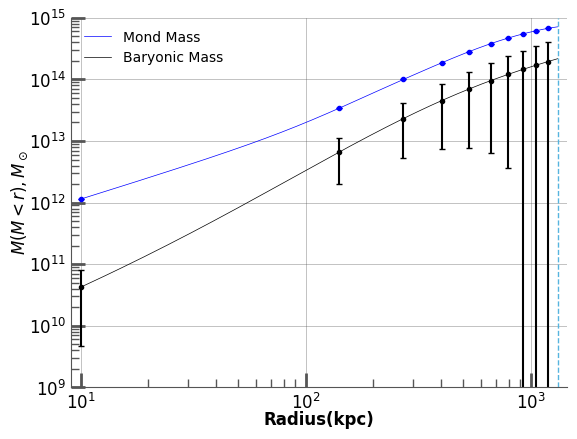

In [22]:
theme = load_theme("scientific")
theme.apply()

plt.xscale('log')
plt.yscale('log')

#plt.plot(radius/conv,newt_masses,label='Newtonian Mass',color='blue',linewidth=0.5)
plt.plot(radius/conv,mond_masses,label='Mond Mass',color='blue',linewidth=0.5)
plt.plot(radius/conv,obs_masses,label='Baryonic Mass',color='black',linewidth=0.5)
#plt.errorbar(radius[::100]/conv,newt_masses[::100],errors[::100],fmt='.',color='blue')
plt.errorbar(radius[::100]/conv,obs_masses[::100],b_errors[::100],capsize=2,fmt='.',color='black')
plt.errorbar(radius[::100]/conv,mond_masses[::100],m_errors[::100],capsize=2,fmt='.',color='blue')

plt.axvline(x=10**3.12,linestyle='--',linewidth=1)
plt.ylim(1e9,1e15)
plt.xlabel('Radius(kpc)',fontweight='bold',fontsize='large')
plt.ylabel('$M(M<r) ,M_\odot$',fontweight='bold',fontsize='large')
plt.legend(frameon=False)
plt.savefig('Fig1.pdf')
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

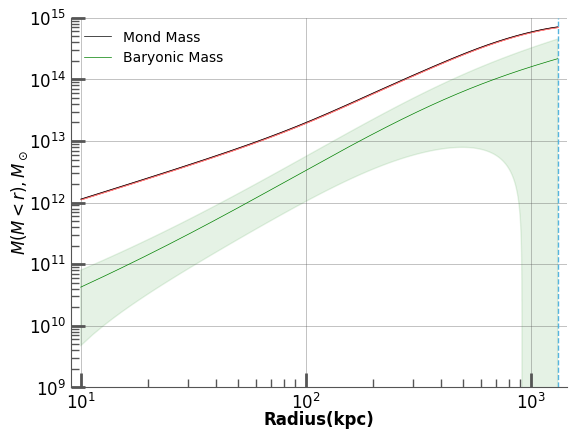

In [23]:
plt.figure()

plt.xscale('log')
plt.yscale('log')

#plt.plot(radius/conv,newt_masses,label='Newtonian Mass',color='blue',linewidth=0.5)
plt.plot(radius/conv,mond_masses,label='Mond Mass',color='black',linewidth=0.5)
plt.plot(radius/conv,obs_masses,label='Baryonic Mass',color='green',linewidth=0.5)
#plt.fill_between(radius/conv,cs_n_max(radius),cs_n_min(radius),color='blue',alpha=0.1)
plt.fill_between(radius/conv,cs_m_max(radius),cs_m_min(radius),color='red',alpha=0.5)
plt.fill_between(radius/conv,cs_o_max(radius),cs_o_min(radius),color='green',alpha=0.1)

plt.axvline(x=10**3.12,linestyle='--',linewidth=1)
plt.ylim(1e9,1e15)
plt.xlabel('Radius(kpc)',fontweight='bold',fontsize='large')
plt.ylabel('$M(M<r) ,M_\odot$',fontweight='bold',fontsize='large')
plt.legend(frameon=False)
plt.savefig('Fig1_fill.pdf')
plt.show()

In [83]:
radius[-244]/conv

1000.0321264751191

In [85]:
((mond_masses-obs_masses)/np.sqrt(b_errors**2+m_errors**2))[-1]

2.11716917349984

In [24]:
mm=pd.read_csv('plot-data.csv')
mg=pd.read_csv('plot-data(1).csv')

mmx=np.power(10,mm['x'].to_numpy())
mmy=np.power(10,mm[' y'].to_numpy())
mgx=np.power(10,mg['x'].to_numpy())
mgy=np.power(10,mg[' y'].to_numpy())

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

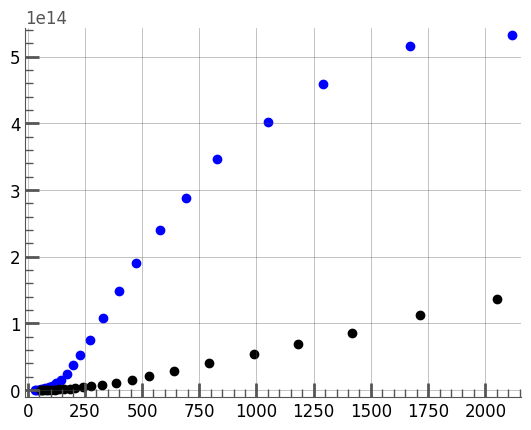

In [39]:
plt.scatter(mmx,mmy,color='blue',label='Mond Mass(Sanders 2003)')
plt.scatter(mgx,mgy,color='black',label='Baryonic Mass(Sanders 2003)')
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

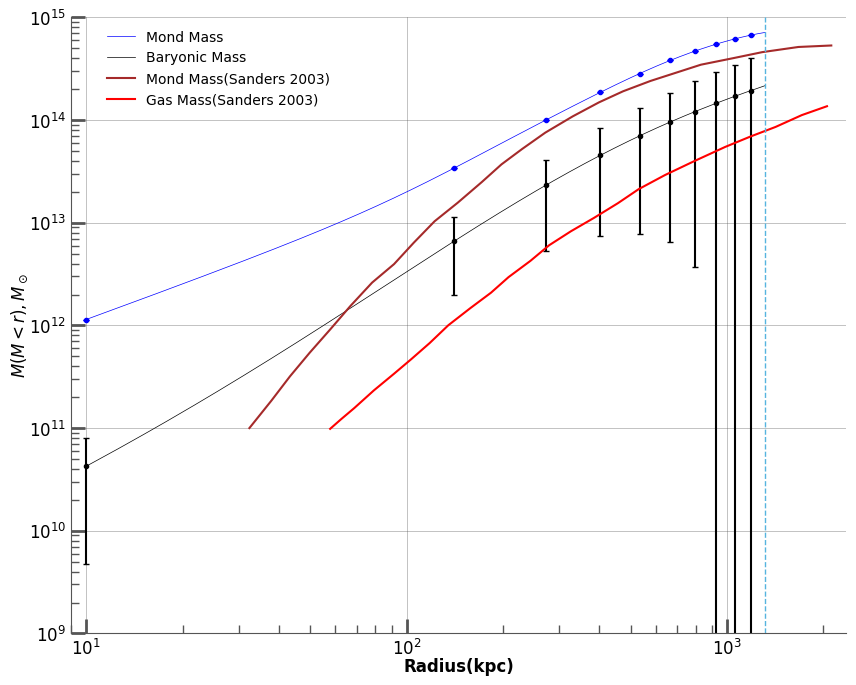

In [44]:
theme = load_theme("scientific")
theme.apply()

plt.figure(figsize=(10,8))
plt.xscale('log')
plt.yscale('log')

#plt.plot(radius/conv,newt_masses,label='Newtonian Mass',color='blue',linewidth=0.5)
plt.plot(radius/conv,mond_masses,label='Mond Mass',color='blue',linewidth=0.5)
plt.plot(radius/conv,obs_masses,label='Baryonic Mass',color='black',linewidth=0.5)
#plt.errorbar(radius[::100]/conv,newt_masses[::100],errors[::100],fmt='.',color='blue')
plt.errorbar(radius[::100]/conv,obs_masses[::100],b_errors[::100],capsize=2,fmt='.',color='black')
plt.errorbar(radius[::100]/conv,mond_masses[::100],m_errors[::100],capsize=2,fmt='.',color='blue')
a=np.argsort(mmx)
b=np.argsort(mgx)
plt.plot(mmx[a],mmy[a],color='brown',label='Mond Mass(Sanders 2003)')
plt.plot(mgx[b],mgy[b],color='red',label='Gas Mass(Sanders 2003)')

plt.axvline(x=10**3.12,linestyle='--',linewidth=1)
plt.ylim(1e9,1e15)
plt.xlabel('Radius(kpc)',fontweight='bold',fontsize='large')
plt.ylabel('$M(M<r) ,M_\odot$',fontweight='bold',fontsize='large')
plt.legend(frameon=False,bbox_to_anchor=(0.35,1))
plt.savefig('Fig1.pdf')
plt.show()

In [45]:
m_errors=np.array([np.float64(i) for i in m_errors])
b_errors=np.array([np.float64(i) for i in b_errors])

## Part-2

In [48]:
# T(10 kpc)
c=4.3
a=-0.07
b=2.5
mags=np.array([T0,r_cool,a_cool,Tmin,rt,a,b,c])
x0=10*conv
create_T(r,mags).subs({r:x0})

63876260.2228803

In [49]:
r=symbols('r')
diff_T=diff(create_T(r,mags),r)
diff_T.evalf(subs={r: x0})

3.14335569563607e-14

In [50]:
def density_at_r(x,param):

    r=symbols('r')
    expr=exp(create_logp(param))
    rho=expr.subs({r:x})
    rhoprime=diff(expr,r).subs({r:x})
    
    return rho,rhoprime

In [51]:
def rk4(x0,y0,stop,param,n=1000):
    '''
    Function to implement Runge Kutta-4 to solve the ODE for T(r) and 
    '''
    x=np.linspace(x0,stop,n,endpoint=True)
    y=np.empty(len(x))
    y[0]=y0
    
    h=(stop-x0)/n
    i=1   
    a0=1.2e-10
    
    coeff=-mu*m_p*np.sqrt(G*a0)/k
    
    while i<len(x):
        
        rho,rhoprime=density_at_r(x[i-1],param)
        rho2,rhoprime2=density_at_r(x[i-1]+h/2,param)
        rho3,rhoprime3=density_at_r(x[i-1]+h,param)
        
        k1=-y[i-1]/rho*rhoprime+coeff*np.sqrt(cs_mond(x[i-1]))/x[i-1]
        k2=-(y[i-1]+k1*h/2)/rho2*rhoprime2+coeff*np.sqrt(cs_mond(x[i-1]+h/2))/(x[i-1]+h/2)
        k3=-(y[i-1]+k2*h/2)/rho2*rhoprime2+coeff*np.sqrt(cs_mond(x[i-1]+h/2))/(x[i-1]+h/2)
        k4=-(y[i-1]+k3*h)/rho3*rhoprime3+coeff*np.sqrt(cs_mond(x[i-1]+h))/(x[i-1]+h)
        
        y[i]=y[i-1]+h/6*(k1+2*k2+2*k3+k4)     
        i=i+1
        
    return x,y

In [38]:
cs_mond=CubicSpline(radius,mond_masses)
r,T=rk4(10*conv,63876260.2228803,10**3.12*conv,mags2,1000)

In [39]:
r=symbols('r')
T_model=np.array([create_T(r,mags).subs({r:x}) for x in radius])

plt.loglog(radius/conv,T/e*k*1e-3,label='T(r) in MOND',color='black')
plt.loglog(radius/conv,T_model/e*k*1e-3,label='Observed T(r)',color='blue')

plt.ylabel('Temperature(keV)')
plt.xlabel('Radius(kpc)')
plt.legend()

In [41]:
a1,b1,c1,d1,e1,f1,g1,h1=symbols('a b c d e f g h')

def errbar_T(rad,param):

    a1,b1,c1,d1,e1,f1,g1,h1=param
    f=0
    r=symbols('r')
    
    for p in range(len(param)):
        difff=diff(create_T(r,param,give_log=False),param[p])
        e=dt[p]**2*(difff.subs(dict(zip(param,mags))).subs({r:rad}))**2
        f=f+e

    f=f**0.5

    return f

ebar=np.array([errbar_T(rad,[a1,b1,c1,d1,e1,f1,g1,h1]) for rad in radius])

In [ ]:
max_temps = -np.inf * np.ones(1000)
min_temps = np.inf * np.ones(1000)

for m in tqdm(range(6)):
    samples = np.random.normal(mags[m], dp[m], 1000)
    valid_samples = samples[(samples > mags2[m] - dp[m]) & (samples < mags2[m] + dp[m])]

    for sample in tqdm(valid_samples):
        mags_copy = mags2.copy()
        mags_copy[m] = sample

        r, temp = rk4(10 * conv, 63851390.53808778, 10**3.12 * conv, np.array(mags_copy))

        max_temps = np.maximum(temp, max_temps)
        min_temps = np.minimum(temp, min_temps)

max_cs=np.array((max_temps/e*k*1e-3)-(T/e*k*1e-3))
min_cs=np.array((T/e*k*1e-3)-(min_temps/e*k*1e-3))
ebar2=0.5*(max_cs+min_cs)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

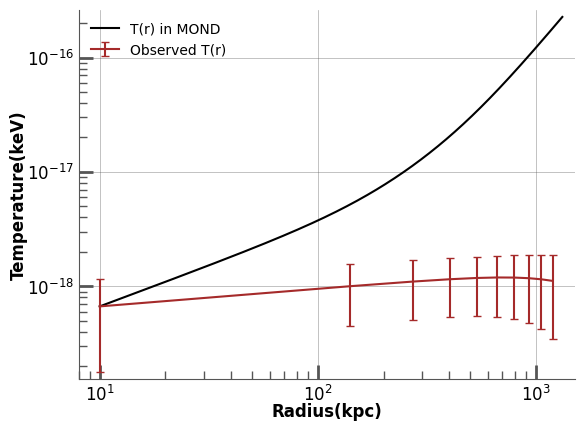

In [45]:
T_model=np.array([create_T(r,mags).subs({r:x}) for x in radius])

plt.xscale('log')
plt.yscale('log')
plt.plot(radius/conv,T/e*k*1e-3,label='T(r) in MOND',color='black')
plt.errorbar(radius[::100]/conv, T_model[::100]/e*k*1e-3,np.array(ebar[::100])/e*k*1e-3,capsize=3,color='brown',label='Observed T(r)')

plt.xlim(8,1.5e3)
plt.ylabel('Temperature(keV)',fontsize='large',fontweight='bold')
plt.xlabel('Radius(kpc)',fontsize='large',fontweight='bold')
plt.legend(frameon=False)
plt.show()
plt.savefig('Fig2.pdf')

In [ ]:
sigma=(np.array(T)-np.array(T_model))/np.sqrt(ebar**2+ebar2**2)
print(np.max(sigma))
print(radius[np.argmax(sigma)])
print(sigma[-1])

## PART-3

In [52]:
from astropy.constants import c
mass_deficit=(np.array(newt_masses)-np.array(obs_masses))*M.value 
mean_rho=np.array(obs_masses)*M.value/(4/3*np.pi*radius**3) 
r=symbols('r')
rho_r=np.array([float(exp(create_logp([n0,rc,alpha,be,rs,e])).subs(r,x)) for x in radius])
delta=rho_r/mean_rho

In [53]:
h0=cosmo.H0
m_dm = np.sqrt(((c*h0/conv/6/G*radius**2*obs_masses*(1+3*delta))).value.astype(float))*(M.value)**0.5

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following famil

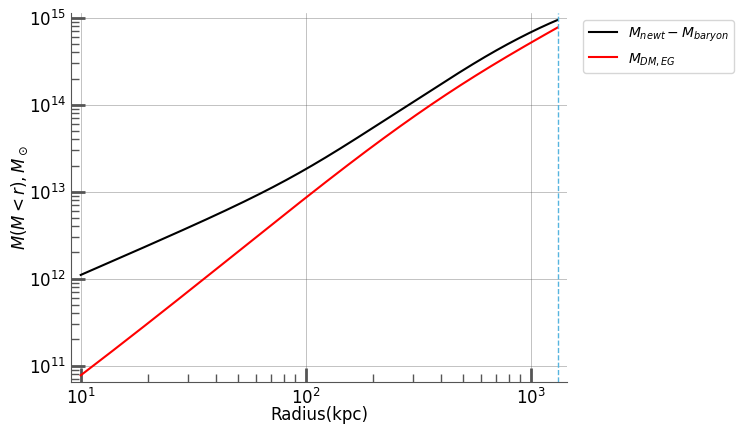

In [54]:
plt.xscale('log')
plt.yscale('log')

plt.plot(radius/conv,mass_deficit/M.value,label='$M_{newt}-M_{baryon}$',color='black')
plt.plot(radius/conv,m_dm/M.value,label='$M_{DM,EG}$',color='red')

plt.axvline(x=10**3.12,linestyle='--',linewidth=1)
plt.xlabel('Radius(kpc)')
plt.ylabel('$M(M<r) ,M_\odot$')
plt.legend(loc='upper right',bbox_to_anchor=(1.35,1))
plt.show()

In [55]:
err2=(errors**2+b_errors**2)**0.5

In [56]:
def errors2(radius, t_errors,dens_errors, dens_params,temp_params,mags,magsd):

    err_array1=[]
    err_array2=[]
    
    for rad in tqdm(radius):
        
        fin_res=0
        param_index=0
        
        T=create_T(r,temp_params)
        p=exp(create_logp(dens_params))
            
        x=diff(p,r)
        y=diff(T,r)

        for param in temp_params:
            
            u=diff(T,param)
            z=diff(y,param)

            res=coeff.value*r**2*(1/p*x*u+z)
            res=res**2*(t_errors[param_index])**2
            fin_res=fin_res+res
            param_index=param_index+1
            
        fin_res=fin_res.subs(dict(zip(dens_params,magsd))).subs(dict(zip(temp_params,mags))).subs({r:rad})
        err_array1.append(fin_res)
        
    i=0
    
    for rad in tqdm(radius):
        
        fin_res=0
        param_index=0
        T=create_T(r,temp_params)
        p=exp(create_logp(dens_params))
        dp=diff(p,r)
        
        for param in dens_params:
            
            res=coeff.value*r**2*T*(-1/p/p*dp*diff(p,param)+1/p*diff(dp,param))
            res2=res**2*(dens_errors[param_index])**2

            fin_res=fin_res+res2+(justerrs[param_index][i]/M.value)**2*(dens_errors[param_index])**2
            -2*res*justerrs[param_index][i]/M.value*(dens_errors[param_index])**2
            param_index=param_index+1

        fin_res=fin_res.subs(dict(zip(dens_params,magsd))).subs(dict(zip(temp_params,mags))).subs({r:rad})
        err_array2.append(fin_res)
        i+=1
    
    err_array3=np.array(justerrs[6])**2*0.01/M.value/M.value
        
    return np.array(err_array1),np.array(err_array2),err_array3

In [57]:
err21,err22,err23=errors2(radius,dt,dp,dens_params,temp_params,mags,mags2)

100%|███████████████████████████████████████| 1000/1000 [05:37<00:00,  2.96it/s]


In [58]:
err2=(err21+err22+err23)**0.5

In [59]:
def p_errors(radius, dens_errors, dens_params,magsd):
    '''
    Returns an array of summation of (dM_n/dphi)**2*sigma(phi)**2 across all phis(density parameters) for all radii
    density_errors=Array of error magnitudes for density parameters
    dens_params=Symbolic variables for density parameters
    magsd=Array of numerical values of density parameters(eROSITA data fit)
    '''
    err_array=[]
    
    for rad in tqdm(radius):
        
        fin_res=0
        param_index=0
        p=exp(create_logp(dens_params))
        
        for param in dens_params:
            
            dp=diff(p,param)
            res=dp**2*(dens_errors[param_index])**2

            fin_res=fin_res+res
            param_index=param_index+1

        fin_res=fin_res.subs(dict(zip(dens_params,magsd))).subs({r:rad})
        err_array.append(fin_res)

    return err_array

In [60]:
temp=np.array(p_errors(radius,dp,dens_params,mags2))

100%|██████████████████████████████████████| 1000/1000 [00:06<00:00, 159.78it/s]


In [61]:
err3=c.value*h0.value/conv/12/G/(m_dm)*radius**2*(
    3*obs_masses*M.value*((rho_r/mean_rho**2/(4*np.pi*radius**3)*b_errors*M.value)+(1/mean_rho*temp**0.5))+
    (1+3*(rho_r/mean_rho)*b_errors*M.value)
)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

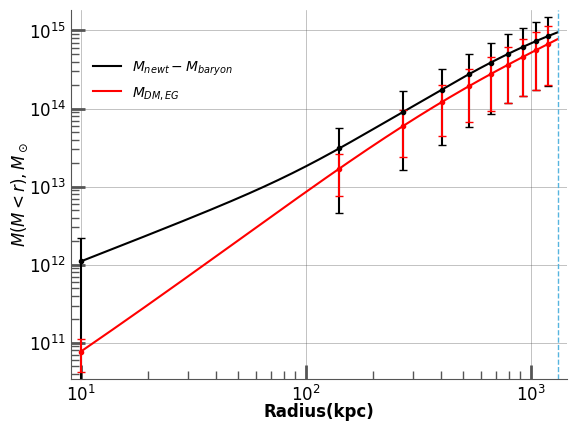

In [66]:
theme = load_theme("scientific")
theme.apply()
plt.xscale('log')
plt.yscale('log')

plt.plot(radius/conv,mass_deficit/M.value,label='$M_{newt}-M_{baryon}$',color='black')
plt.plot(radius/conv,m_dm/M.value,label='$M_{DM,EG}$',color='red')
plt.errorbar(radius[::100]/conv,mass_deficit[::100]/M.value,err2[::100],capsize=3,fmt='.',color='black')
plt.errorbar(radius[::100]/conv,m_dm[::100]/M.value,err3[::100]/M.value,capsize=3,fmt='.',color='red')

plt.axvline(x=10**3.12,linestyle='--',linewidth=1)
plt.xlabel('Radius(kpc)',fontweight='bold',fontsize='large')
plt.ylabel('$M(M<r) ,M_\odot$',fontweight='bold',fontsize='large')
plt.legend(loc='upper right',bbox_to_anchor=(0.35,0.9),frameon=False)
plt.grid('False')
plt.savefig('Fig3.pdf')
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

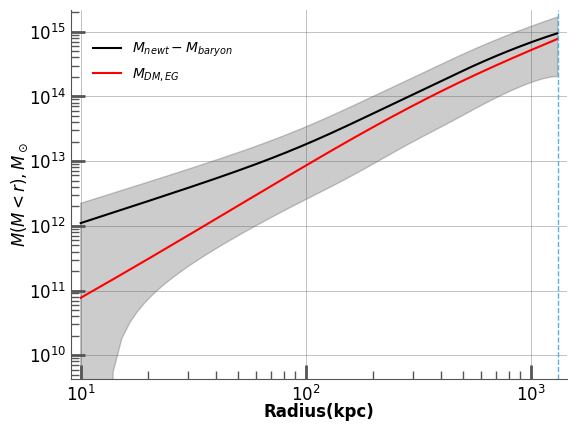

In [69]:
cs1=CubicSpline(radius/conv,mass_deficit/M.value+err2)
cs2=CubicSpline(radius/conv,mass_deficit/M.value-err2)
cs3=CubicSpline(radius/conv,m_dm/M.value+err3)
cs4=CubicSpline(radius/conv,m_dm/M.value-err3)

plt.xscale('log')
plt.yscale('log')

plt.plot(radius/conv,mass_deficit/M.value,label='$M_{newt}-M_{baryon}$',color='black')
plt.plot(radius/conv,m_dm/M.value,label='$M_{DM,EG}$',color='red')
#plt.errorbar(radius[::100]/conv,mass_deficit[::100]/M.value,err2[::100],capsize=3,fmt='.',color='black')
#plt.errorbar(radius[::100]/conv,m_dm[::100]/M.value,err3[::100]/M.value,capsize=3,fmt='.',color='red')
plt.fill_between(radius/conv,cs1(radius/conv),cs2(radius/conv),color='black',alpha=0.2)
#plt.fill_between(radius/conv,cs3(radius/conv),cs4(radius/conv),color='red',alpha=0.2)

plt.axvline(x=10**3.12,linestyle='--',linewidth=1)
plt.xlabel('Radius(kpc)',fontweight='bold',fontsize='large')
plt.ylabel('$M(M<r) ,M_\odot$',fontweight='bold',fontsize='large')
plt.legend(loc='upper right',bbox_to_anchor=(0.35,0.95),frameon=False)
plt.grid('False')
plt.savefig('Fig3_fill.pdf')
plt.show()

In [57]:
err2=np.array([np.float64(i) for i in err2])
err3=np.array([np.float64(i) for i in err3])
np.max((mass_deficit/M.value-m_dm/M.value)/np.sqrt((err2)**2+(err3/M.value)**2))

0.910330955994966

In [58]:
radius[1]/conv

11.309566304861269

In [87]:
((mass_deficit/M.value-m_dm/M.value)/((err2)**2+(err3/M.value)**2)**0.5)[-1]

0.185161609840243